# AlBi 3
### Übungsblatt 7
*Markus Apel, Mathias Husted*

### Aufgabe 1: Genstruktur I
**a) Warum unterscheidet man in der Genstrukturvorhersage zwischen Eukaryonten und
Prokaryonten?**

Man unterscheidet zwischen Pro- und Eukaryonten, weil die Gene unterschiedlich unterteilt sind.

In **Prokaryonten** werden Gene konsekutiv meist in Operons organisiert, während sie in **Eukaryonten** eine Intron-Exon-Struktur besitzen. Daher wird zusätzlich z.B. die Erkennung von Splice Sites benötigt.

**b) Was sind Indikatoren für proteinkodierende Abschnitte im Genom die sich Genfindungsprogramme zu nutze machen können?**

- Start- und Stoppcodon
- Splice-Sites bei Eukaryonten
- Ribosomal binding site bei Prokaryonten
- Upstream regulatory motifs (Promoter, TATA, etc.)
- Poly-A-Schwanz
- Lange ORFs
- Codonpräferenzen (Leserahmenkonsistenz)

**c) Mit welchem Hobby vergleicht Anders Krogh das Finden von Signalen in Genen und
weshalb?**

Anders Krogh vergleicht es mit Vogelbeobachtung und zieht die Analogie heran, dass man bei der Erkennung von "Vögel" die Umgebungen mit betrachten muss. Bei der Findung von Genen können das Kontextsignale wie benachbarte Exons/Introns sein.

### Aufgabe 2: Genstruktur II
Gegeben ist die Sequenz:

ATGCGCTAGCGGATGATGAGGCCCTAGATGGCC

**a) Finden Sie die Start- und Stopcodons in der DNA Sequenz. Welche ORFs werden
dadurch definiert? Was ist ihre Länge?**

In [2]:
def find_reading_frames(input):
    # Find start codon ATG
    starting_points = []
    for i, letter in enumerate(input):
        if input[i:i+3] == "ATG":
            starting_points.append(i)
    print(f"Starting points found at {starting_points}")
    
    # Find stop of each point
    stop_codons = ["TAA", "TAG", "TGA"]
    reading_frames = []
    for i in starting_points:
        starting_frame = i
        while starting_frame != len(input) - 3:
            print(input[starting_frame:starting_frame+3])

            if input[starting_frame:starting_frame+3] in stop_codons:
                reading_frames.append((i, starting_frame + 3))
                break
            starting_frame += 3 # Move frame by a codon (3 bp)
    print(f"Reading frames: {reading_frames} with lengths: {[y-x for (x,y) in reading_frames]}")
        


find_reading_frames("ATGCGCTAGCGGATGATGAGGCCCTAGATGGCC")

Starting points found at [0, 12, 15, 27]
ATG
CGC
TAG
ATG
ATG
AGG
CCC
TAG
ATG
AGG
CCC
TAG
ATG
Reading frames: [(0, 9), (12, 27), (15, 27)] with lengths: [9, 15, 12]


**b) Es wurden drei reading frames bestimmt und deren $p_i$ ermittelt. Berechnen Sie nun
$P_1$ und erläutern Sie das Ergebnis.**
$$
p_1 = 0.005\\
p_2 = 0.009\\
p_3 = 0.001
$$

In [3]:
def P_i(pi, p1, p2, p3):
    return pi/(p1+p2+p3)

p1 = 0.005
p2 = 0.009
p3 = 0.001

pi_1 = P_i(p1, p1, p2, p3)
pi_2 = P_i(p2, p1, p2, p3)
pi_3 = P_i(p3, p1, p2, p3)

print(f"P_1: {pi_1}, P_2: {pi_2}, P_3: {pi_3}")


P_1: 0.33333333333333337, P_2: 0.6, P_3: 0.06666666666666667


Es gilt $P_1 \approx 33.3 \%$. Das bedeutet, dass Reading Frame 1 mit 33% das codierende Leseraster ist. Man muss es ins Verhältnis zu den Alternativhypothesen setzen, nämlich $P_2 = 60\%$ und $P_3 \approx 6.6\%$

Also ist $P_1$ tatsächlich mit geringerer Wahrscheinlichkeit das richtige Leseraster als $P_2$.

### Aufgabe 3: Genvorhersage
Suchen Sie Gene im Genom von S. cervisiae mittels einer Markovkette 3. Ordnung.
a) Laden Sie die Fasta-Dateien mit 1000 proteinkodierenden Gensequenzen (y_genes.txt)
und mit nicht-kodierenden DNA-Sequenzen (y_ncregions.txt) herunter. Schreiben Sie
eine Funktion, die aus den Sequenzen in y_genes.txt eine Markovkette 3. Ordnung für
die Gene (das Gen-Modell G) schätzt.

Die Transitionswahrscheinlichkeiten $a^{G}_{rst,u}$ können Sie wie folgt berechnen:

$$\frac{c^{G}_{rst,u}}{\sum_{l} c^{G}_{rst,l}}$$

,
wobei $c^{G}_{rst,u}$ die Zahl der $rstu$-Tetranukleotide in den Sequenzen aus
y_genes.txt ist. Geben Sie die Transitionsmatrix für das G-Modell an, runden Sie
dabei die Wahrscheinlichkeiten auf 3 Dezimalstellen.

In [4]:
# First, we'll create a function to load the fasta file

def read_fasta(filename):
    sequences = []
    current = []
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if current:
                    sequences.append("".join(current))
                    current = []
            else:
                current.append(line.lower())
        if current:
            sequences.append("".join(current))
    return sequences

sequences = read_fasta("y_genes.txt")

In [5]:
import numpy
# Transition matrix

bases = ["a", "c", "g", "t"]

def build_markov_chain(sequences):
    counts = {}
    # Create individual keys
    for seq in sequences:
        for i in range(len(seq) - 3):
            rst = seq[i:i+3]
            u = seq[i+3]
            if rst not in counts:
                counts[rst] = {'a': 0, 'c': 0, 'g': 0, 't': 0}
            
            counts[rst][u] += 1
    
    # Now create transition matrix

    transition_matrix = {}

    for rst in counts:
        counts_sum = counts[rst]['a'] + counts[rst]['c'] + counts[rst]['g'] + counts[rst]['t']

        transition_matrix[rst] = {}

        for base in bases:
            transition_matrix[rst][base] = round(counts[rst][base] / counts_sum, 3) if counts_sum > 0 else 0
    
    return transition_matrix
        

model_g = build_markov_chain(sequences)

model_g
            

{'atg': {'a': 0.364, 'c': 0.184, 'g': 0.247, 't': 0.206},
 'tgc': {'a': 0.284, 'c': 0.254, 'g': 0.105, 't': 0.357},
 'gcc': {'a': 0.46, 'c': 0.154, 'g': 0.155, 't': 0.231},
 'cca': {'a': 0.385, 'c': 0.183, 'g': 0.198, 't': 0.233},
 'caa': {'a': 0.332, 'c': 0.186, 'g': 0.256, 't': 0.226},
 'aat': {'a': 0.25, 'c': 0.205, 'g': 0.228, 't': 0.317},
 'att': {'a': 0.241, 'c': 0.212, 'g': 0.244, 't': 0.304},
 'tta': {'a': 0.265, 'c': 0.242, 'g': 0.182, 't': 0.311},
 'tat': {'a': 0.206, 'c': 0.241, 'g': 0.209, 't': 0.344},
 'ata': {'a': 0.301, 'c': 0.231, 'g': 0.134, 't': 0.334},
 'tag': {'a': 0.426, 'c': 0.196, 'g': 0.163, 't': 0.215},
 'agg': {'a': 0.336, 'c': 0.196, 'g': 0.148, 't': 0.32},
 'ggg': {'a': 0.313, 'c': 0.22, 'g': 0.141, 't': 0.326},
 'ggt': {'a': 0.293, 'c': 0.155, 'g': 0.295, 't': 0.257},
 'gtg': {'a': 0.297, 'c': 0.198, 'g': 0.294, 't': 0.212},
 'ccg': {'a': 0.309, 'c': 0.201, 'g': 0.191, 't': 0.299},
 'cga': {'a': 0.369, 'c': 0.185, 'g': 0.17, 't': 0.276},
 'gag': {'a': 0.399

b) Schätzen Sie aus den Sequenzen in y_ncregions.txt eine Markovkette für ein Hintergrundmodell (das Noncoding-Modell NC). 

Die Berechnung von $a^{NC}_{rst,u}$ erfolgt analog
zu den $a^{G}_{rst,u}$ mit den Sequenzen aus y_genes.txt. Geben Sie die Transitionsmatrix für
das NC-Modell an.

In [6]:
nc_file = read_fasta('y_ncregions.txt')

model_nc = build_markov_chain(nc_file)

model_nc

{'gat': {'a': 0.287, 'c': 0.216, 'g': 0.211, 't': 0.285},
 'atc': {'a': 0.33, 'c': 0.207, 'g': 0.156, 't': 0.307},
 'tct': {'a': 0.193, 'c': 0.231, 'g': 0.163, 't': 0.412},
 'ctc': {'a': 0.26, 'c': 0.199, 'g': 0.124, 't': 0.417},
 'tcg': {'a': 0.342, 'c': 0.175, 'g': 0.15, 't': 0.333},
 'cgc': {'a': 0.259, 'c': 0.266, 'g': 0.182, 't': 0.293},
 'gca': {'a': 0.357, 'c': 0.196, 'g': 0.212, 't': 0.236},
 'caa': {'a': 0.351, 'c': 0.175, 'g': 0.204, 't': 0.269},
 'aag': {'a': 0.402, 'c': 0.181, 'g': 0.194, 't': 0.223},
 'agt': {'a': 0.294, 'c': 0.185, 'g': 0.234, 't': 0.287},
 'gtg': {'a': 0.307, 'c': 0.183, 'g': 0.237, 't': 0.273},
 'tgc': {'a': 0.307, 'c': 0.223, 'g': 0.125, 't': 0.345},
 'cat': {'a': 0.281, 'c': 0.234, 'g': 0.162, 't': 0.323},
 'att': {'a': 0.219, 'c': 0.198, 'g': 0.22, 't': 0.363},
 'ttc': {'a': 0.273, 'c': 0.248, 'g': 0.11, 't': 0.37},
 'tcc': {'a': 0.326, 'c': 0.232, 'g': 0.1, 't': 0.342},
 'cct': {'a': 0.162, 'c': 0.281, 'g': 0.144, 't': 0.413},
 'cta': {'a': 0.279, '

c) Untersuchen Sie jetzt die Sequenz in der Datei test.txt. Schreiben Sie eine Funktion,
die über diese Sequenz One-by-One ein Fenster schiebt und für jede Position des
Fensters die Log-Likelihood-Ratio berechnet:

$$S(x_k, ..., x_{k+w−1}) = \log \frac{Pr(x_k, ..., x_{k+w−1} | \text{model G})}{Pr(x_k, ..., x_{k+w−1} | \text{model NC})} = \sum^{k+w-1}_{i=k} \log \frac{a^G_{x_{i-3}x_{i-2}x_{x-1},x_i}}{a^{NC}_{x_{i-3}x_{i-2}x_{x-1},x_i}}$$

Die Funktion übernimmt dabei die Fenstergröße w = 5000bp als Parameter. Speichern
Sie den Ergebnisvektor S in einer Datei.

In [9]:
import numpy as np

def log_likelihood_single_seq(filename, window_size, model_g, model_nc, result_file):
    seq = read_fasta(filename)[0]
    
    s = []

    for i in range(len(seq) - window_size + 1):
        if i % 1000 == 0:
            print(f"i = {i}")
            
        log_sum = 0
        for j in range(i + 3, i + window_size):
            rst = seq[j-3:j]
            u = seq[j]

            if rst not in model_g or rst not in model_nc:
                continue

            next_p_g = model_g[rst][u]
            next_p_nc = model_nc[rst][u]

            if next_p_g == 0 or next_p_nc == 0:
                continue

            log_sum += np.log(next_p_g / next_p_nc)
        
        s.append(log_sum)
    
    with open(result_file, "w") as f:
        for val in s:
            f.write(str(val) + "\n")

    return s

log_likelihood_single_seq("test.txt", 5000, model_g, model_nc, "test_results.txt")
print("Saved results in test_results.txt!")


i = 0
i = 1000
i = 2000
i = 3000
i = 4000
i = 5000
i = 6000
i = 7000
i = 8000
i = 9000
i = 10000
i = 11000
i = 12000
i = 13000
i = 14000
i = 15000
i = 16000
i = 17000
i = 18000
i = 19000
i = 20000
i = 21000
i = 22000
i = 23000
i = 24000
i = 25000
i = 26000
i = 27000
i = 28000
i = 29000
i = 30000
i = 31000
i = 32000
i = 33000
i = 34000
i = 35000
i = 36000
i = 37000
i = 38000
i = 39000
i = 40000
i = 41000
i = 42000
i = 43000
i = 44000
i = 45000
Saved results in test_results.txt!


d) Erstellen Sie einen Plot, in dem Sie den Ergebnisvektor S der Log-Likelihood-Ratios
darstellen. Fügen Sie eine geglättete Version des Ergebnisvektors hinzu (z.B. in R mit
`smooth.spline())` und außerdem eine Nullinie. Wie viele Gene erkennen Sie? Fügen
Sie den Plot der Abgabe bei.

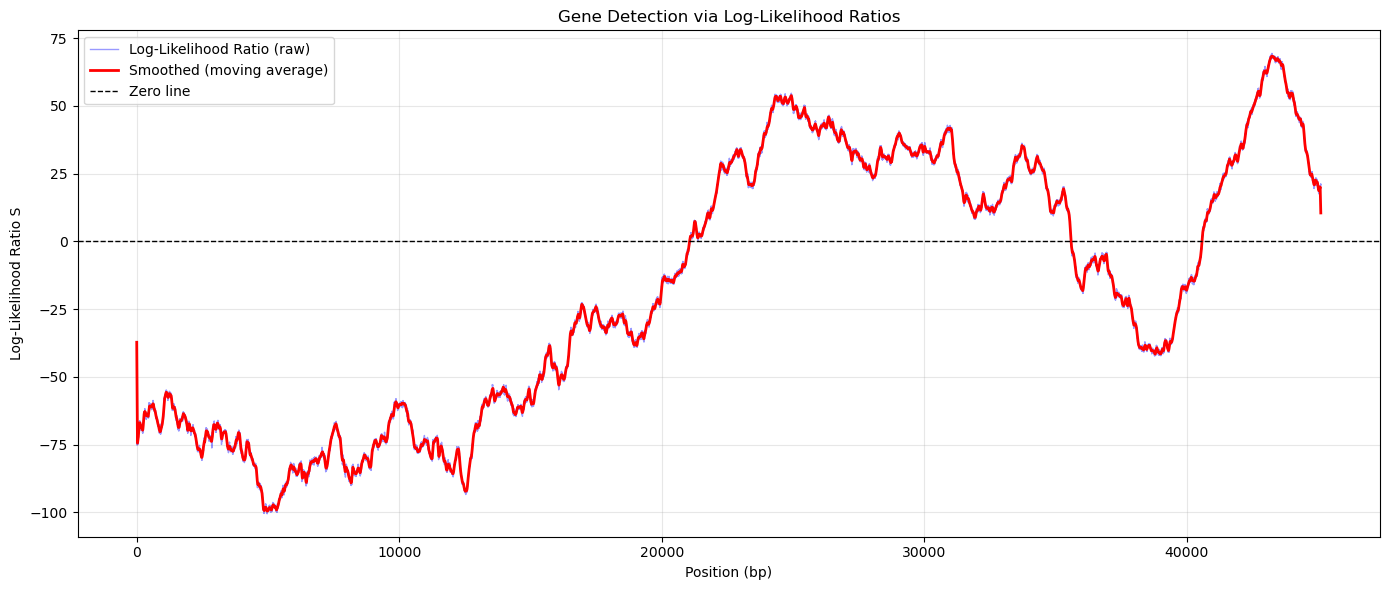

Number of genes estimated = 2


(array([-73.51059 , -73.53147 , -73.938515, ...,  21.022358,  21.23126 ,
         20.93061 ], shape=(45100,), dtype=float32),
 array([-37.2476445 , -38.7253125 , -40.20573242, ...,  11.30323986,
         10.89859798,  10.49733765], shape=(45100,)))

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def plot_result(result_file):
    s = []
    with open(result_file, "r") as file:
        for line in file:
            line = line.strip()
            s.append(np.float32(line))
    
    s = np.array(s)
    x = np.arange(len(s))
    
    window = 50
    s_smooth = np.convolve(s, np.ones(window)/window, mode='same')

    plt.figure(figsize=(14, 6))
    plt.plot(x, s, alpha=0.4, label='Log-Likelihood Ratio (raw)', linewidth=1, color='blue')
    plt.plot(x, s_smooth, 'r-', linewidth=2, label='Smoothed (moving average)')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label='Zero line')
    
    plt.xlabel('Position (bp)')
    plt.ylabel('Log-Likelihood Ratio S')
    plt.title('Gene Detection via Log-Likelihood Ratios')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('gene_detection_plot.png', dpi=150)
    plt.show()

    gene_regions = s_smooth > 0 # Threshold is 0
    gene_count = 0
    in_gene = False
    for i, is_gene in enumerate(gene_regions):
        if is_gene and not in_gene:
            gene_count += 1
            in_gene = True
        elif not is_gene and in_gene:
            in_gene = False
    print(f"Number of genes estimated = {gene_count}")

    return s, s_smooth


plot_result("test_results.txt")

e) In dieser Aufgabe wurden die Readingframes nicht berücksichtigt. Erklären Sie, worum
es sich dabei handelt und beschreiben Sie, wie der Code angepasst werden müsste,
um dieses Problem zu berücksichtigen.

DNA kann in drei möglichen Leserastern gelesen werden (jeweils Offset 0, 1 ode r2). Dabei ändert sich die Codon-Gruppierung, allerdings ist nur eins der Leseraster das richtige.

Der Code müsste für jeden ORF getrennt lesen rechnen, und dabei evtl. getrennte oder framespezifische Modelle benutzen bzw. das Leseraster auf Basis der Codon-Häufigkeiten in jedem Organismus bestimmen.